In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras import Model
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
IMG_SIZE = 48

In [3]:
for dir in os.listdir("data/test"):
    img_name = f'data/test/{dir}/test_{dir}_1.jpg'
    img = cv2.imread(img_name)
    cv2.imshow(f'Image_{dir}', img)
    cv2.resizeWindow(f'Image_{dir}', 500, 500)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
er_labels = os.listdir("data/test")

In [5]:
def plot_count_of_image(set):
    count = {dir : len(os.listdir(f'data/{set}/{dir}')) for dir in os.listdir(f"data/{set}")}
    plt.bar(list(count.keys()), list(count.values()))
    plt.ylabel('No. of Images')
    plt.xlabel('Emotion')
    plt.title(f'Count of {set}')
    plt.show()

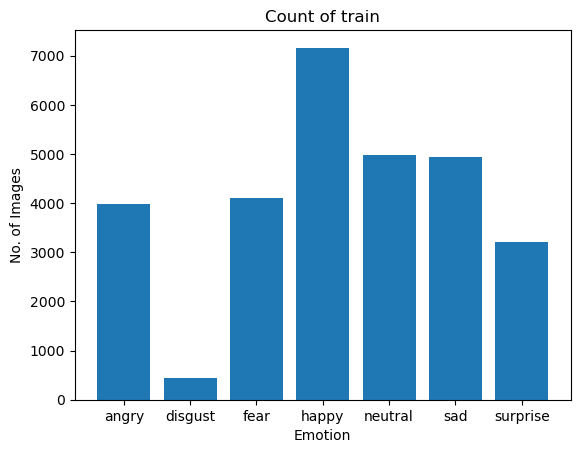

In [6]:
plot_count_of_image('train')

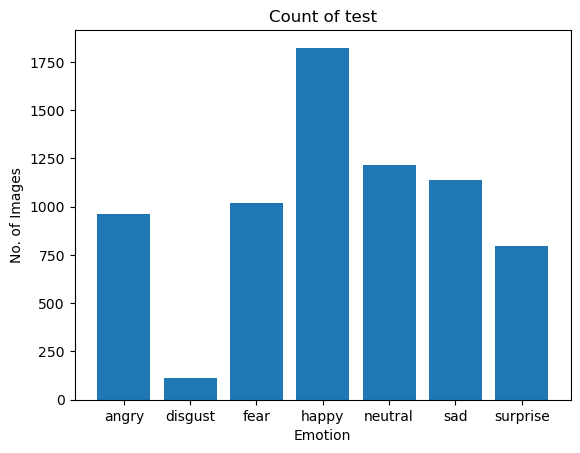

In [7]:
plot_count_of_image('test')

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [9]:
def rescale(set):
    img = []
    label = []
    for dir in os.listdir(f'data/{set}'):
        for image in os.listdir(f'data/{set}/{dir}'):
            path = f'D:\\Codebase\\AI\\Emotion Recognition\\data\\{set}\\{dir}\\{image}'
            img_resized = resize_and_rescale(cv2.imread(path))
            img.append(img_resized)
            label.append(er_labels.index(dir))
    return np.asarray(img), np.asarray(label)

In [10]:
x_train, y_train = rescale("train")
x_test, y_test = rescale("test")

In [11]:
def shuffle(x , y):
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [12]:
x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)
x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test)

In [13]:
y_train_shuffled = tf.keras.utils.to_categorical(y_train_shuffled, 7)
y_test_shuffled = tf.keras.utils.to_categorical(y_test_shuffled, 7)

In [14]:
print(x_train_shuffled.shape)
print(y_train_shuffled.shape)

(28820, 48, 48, 3)
(28820, 7)


In [15]:
eighty_percent_index = int(x_train_shuffled.shape[0] * 0.8)
x_train_final = x_train_shuffled[:eighty_percent_index]
y_train_final = y_train_shuffled[:eighty_percent_index]
x_val_final = x_train_shuffled[eighty_percent_index:]
y_val_final = y_train_shuffled[eighty_percent_index:]

In [16]:
print(x_train_final.shape)
print(y_train_final.shape)

(23056, 48, 48, 3)
(23056, 7)


In [17]:
print(x_val_final.shape)
print(y_val_final.shape)

(5764, 48, 48, 3)
(5764, 7)


Text(0.5, 1.0, 'happy')

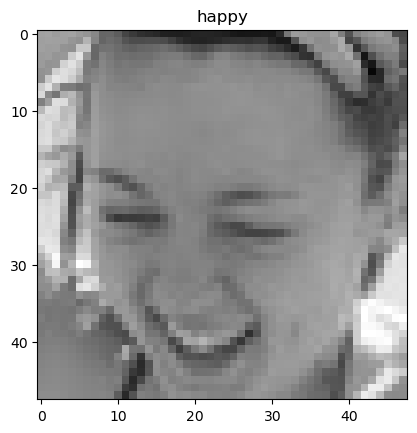

In [18]:
plt.imshow(x_train_final[20453])
plt.title(er_labels[np.argmax(y_train_final[20453])])

In [19]:
def stats(y_pred):
    print(classification_report(y_test_shuffled.argmax(axis=1), y_pred.argmax(axis=1) ,target_names=er_labels))

In [31]:
def visualise_few_images(y_hat):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test_shuffled.shape[0], size=15, replace=False)):
        ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test_shuffled[index]))
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test_shuffled[index])
        # Set the title for each image
        ax.set_title("{} ({})".format(er_labels[predict_index], 
                                      er_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))

In [21]:
def train_validation_acc_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [22]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)       

In [23]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [24]:
model_history1 = model.fit(x_train_final,
         y_train_final,
         batch_size=64,
         epochs=10,
         validation_data=(x_val_final,y_val_final))

Epoch 1/10
361/361 [==============================] - 63s 171ms/step - loss: 1.8009 - accuracy: 0.2600 - val_loss: 1.7018 - val_accuracy: 0.3437
Epoch 2/10
361/361 [==============================] - 61s 170ms/step - loss: 1.6546 - accuracy: 0.3477 - val_loss: 1.5656 - val_accuracy: 0.3942
Epoch 3/10
361/361 [==============================] - 61s 168ms/step - loss: 1.5822 - accuracy: 0.3904 - val_loss: 1.5202 - val_accuracy: 0.4218
Epoch 4/10
361/361 [==============================] - 61s 168ms/step - loss: 1.5252 - accuracy: 0.4092 - val_loss: 1.4640 - val_accuracy: 0.4400
Epoch 5/10
361/361 [==============================] - 60s 167ms/step - loss: 1.4776 - accuracy: 0.4336 - val_loss: 1.4425 - val_accuracy: 0.4535
Epoch 6/10
361/361 [==============================] - 60s 168ms/step - loss: 1.4451 - accuracy: 0.4430 - val_loss: 1.3911 - val_accuracy: 0.4556
Epoch 7/10
361/361 [==============================] - 60s 167ms/step - loss: 1.4088 - accuracy: 0.4642 - val_loss: 1.3646 - val_ac

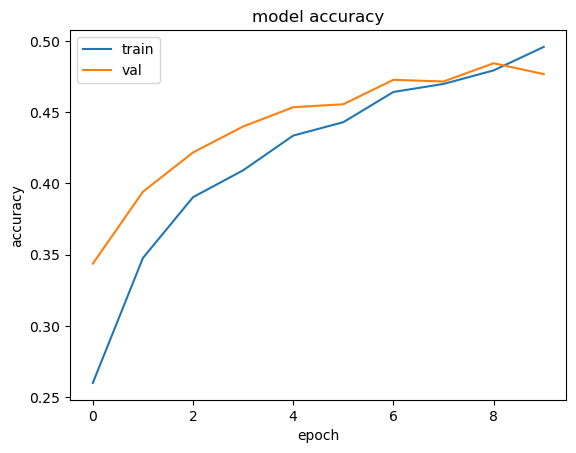

In [25]:
train_validation_acc_plot(model_history1)

In [26]:
model.save('Model_ER.md5')

INFO:tensorflow:Assets written to: Model_ER.md5\assets


INFO:tensorflow:Assets written to: Model_ER.md5\assets


In [27]:
# model = keras.models.load_model('Model_ER.md5')

In [28]:
score = model.evaluate(x_test_shuffled, y_test_shuffled, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.49525830149650574


221/221 [==============================] - 4s 19ms/step


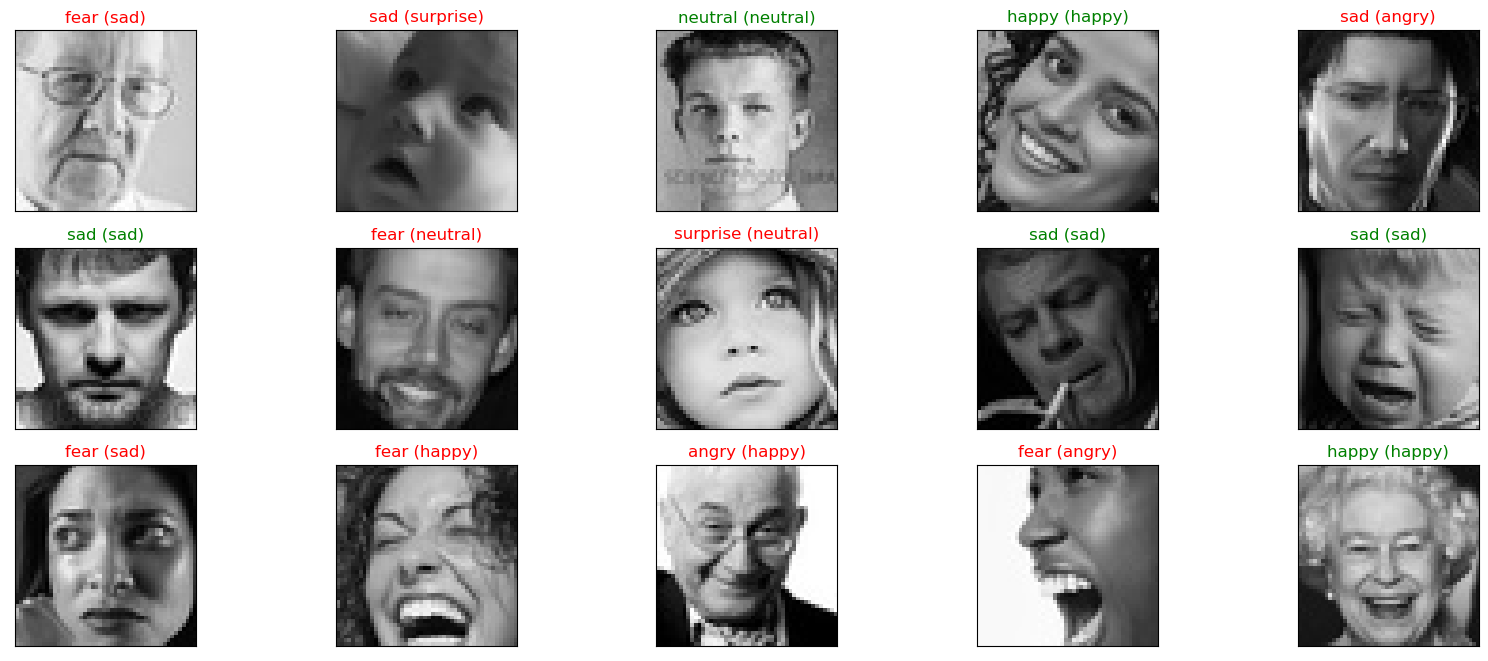

In [32]:
y_pred = model.predict(x_test_shuffled)
visualise_few_images(y_pred)

In [33]:
stats(y_pred)

              precision    recall  f1-score   support

       angry       0.42      0.25      0.31       960
     disgust       0.75      0.05      0.10       111
        fear       0.32      0.38      0.35      1018
       happy       0.70      0.72      0.71      1824
     neutral       0.49      0.43      0.46      1216
         sad       0.35      0.49      0.40      1139
    surprise       0.65      0.61      0.63       797

    accuracy                           0.50      7065
   macro avg       0.53      0.42      0.42      7065
weighted avg       0.51      0.50      0.49      7065



## With More Layers 

In [34]:
model2 = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model2.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,3))) 
model2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(7, activation='softmax'))

# Take a look at the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 1024)      28672     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 1024)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 1024)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 512)       4719104   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 512)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 512)      

In [35]:
model2.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [36]:
model_history2 = model2.fit(x_train_final,
         y_train_final,
         batch_size=64,
         epochs=10,
         validation_data=(x_val_final,y_val_final))

Epoch 1/10
361/361 [==============================] - 3595s 10s/step - loss: 1.8476 - accuracy: 0.2397 - val_loss: 1.8093 - val_accuracy: 0.2469
Epoch 2/10
361/361 [==============================] - 3594s 10s/step - loss: 1.8036 - accuracy: 0.2481 - val_loss: 1.8005 - val_accuracy: 0.2274
Epoch 3/10
361/361 [==============================] - 3615s 10s/step - loss: 1.6914 - accuracy: 0.3205 - val_loss: 1.6958 - val_accuracy: 0.3218
Epoch 4/10
361/361 [==============================] - 3617s 10s/step - loss: 1.5647 - accuracy: 0.3849 - val_loss: 1.5303 - val_accuracy: 0.4141
Epoch 5/10
361/361 [==============================] - 3607s 10s/step - loss: 1.4741 - accuracy: 0.4280 - val_loss: 1.4228 - val_accuracy: 0.4426
Epoch 6/10
361/361 [==============================] - 3602s 10s/step - loss: 1.4043 - accuracy: 0.4587 - val_loss: 1.4468 - val_accuracy: 0.4481
Epoch 7/10
361/361 [==============================] - 3600s 10s/step - loss: 1.3540 - accuracy: 0.4807 - val_loss: 1.3094 - val_ac

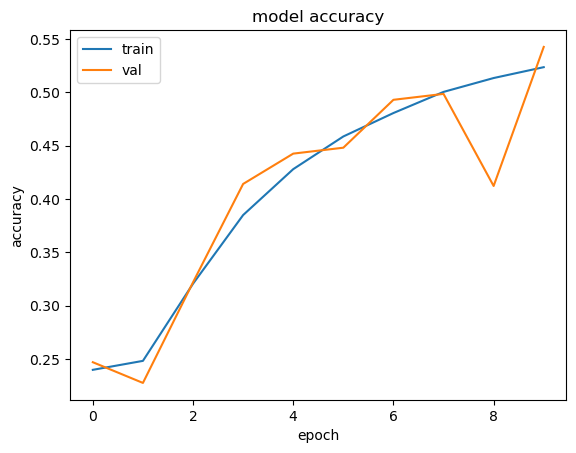

In [37]:
train_validation_acc_plot(model_history2)

In [38]:
model2.save('Mode_Improved_ER.md5')

INFO:tensorflow:Assets written to: Mode_Improved_ER.md5\assets


INFO:tensorflow:Assets written to: Mode_Improved_ER.md5\assets


In [39]:
# model = keras.models.load_model('Mode_Improved_ER.md5')

In [40]:
score = model2.evaluate(x_test_shuffled, y_test_shuffled, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5418258905410767


221/221 [==============================] - 261s 1s/step


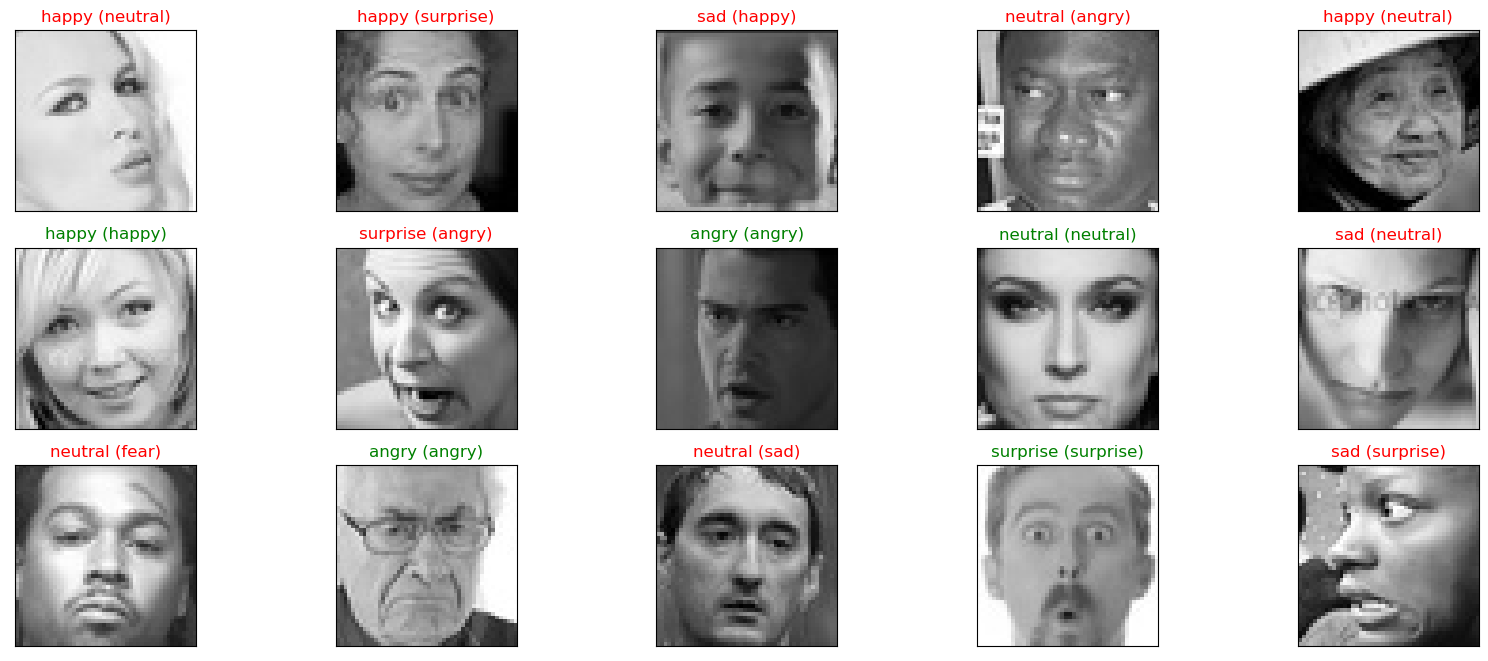

In [41]:
y_pred2 = model2.predict(x_test_shuffled)
visualise_few_images(y_pred2)

In [42]:
stats((y_pred2))

              precision    recall  f1-score   support

       angry       0.46      0.42      0.44       960
     disgust       0.65      0.10      0.17       111
        fear       0.43      0.13      0.20      1018
       happy       0.71      0.83      0.77      1824
     neutral       0.50      0.50      0.50      1216
         sad       0.37      0.63      0.46      1139
    surprise       0.76      0.57      0.65       797

    accuracy                           0.54      7065
   macro avg       0.55      0.45      0.46      7065
weighted avg       0.55      0.54      0.52      7065



## Transfer Learning

In [43]:
base_model = vgg.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
last = base_model.get_layer('block3_pool').output

for layer in base_model.layers:
     layer.trainable = False

In [44]:
x = tf.keras.layers.GlobalAveragePooling2D()(last)
x= tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

#Top
top = tf.keras.layers.Dense(7, activation='softmax')(x)

#Final Model
model_transfer = Model(base_model.input, top)
model_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [45]:
model_transfer.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [46]:
history_transfer = model_transfer.fit(x_train_final,
                                     y_train_final,
                                     batch_size=64,
                                     epochs=15,
                                     validation_data=(x_val_final,y_val_final))

Epoch 1/15
361/361 [==============================] - 157s 432ms/step - loss: 1.6185 - accuracy: 0.3700 - val_loss: 1.4400 - val_accuracy: 0.4502
Epoch 2/15
361/361 [==============================] - 156s 433ms/step - loss: 1.4446 - accuracy: 0.4450 - val_loss: 1.3687 - val_accuracy: 0.4735
Epoch 3/15
361/361 [==============================] - 158s 437ms/step - loss: 1.3698 - accuracy: 0.4788 - val_loss: 1.3472 - val_accuracy: 0.4880
Epoch 4/15
361/361 [==============================] - 158s 437ms/step - loss: 1.3239 - accuracy: 0.4944 - val_loss: 1.3216 - val_accuracy: 0.4971
Epoch 5/15
361/361 [==============================] - 160s 443ms/step - loss: 1.2838 - accuracy: 0.5109 - val_loss: 1.3053 - val_accuracy: 0.4974
Epoch 6/15
361/361 [==============================] - 157s 436ms/step - loss: 1.2468 - accuracy: 0.5267 - val_loss: 1.2993 - val_accuracy: 0.5061
Epoch 7/15
361/361 [==============================] - 158s 437ms/step - loss: 1.2030 - accuracy: 0.5431 - val_loss: 1.2866 -

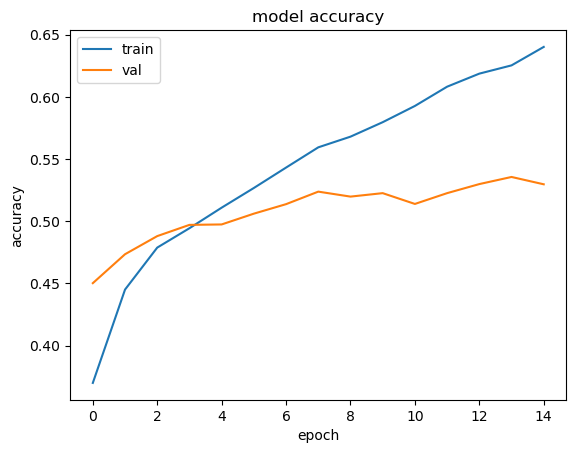

In [47]:
train_validation_acc_plot(history_transfer)

In [48]:
model_transfer.save('Mode_Transfer_Learning_ER.md5')

INFO:tensorflow:Assets written to: Mode_Transfer_Learning_ER.md5\assets


INFO:tensorflow:Assets written to: Mode_Transfer_Learning_ER.md5\assets


In [49]:
score, acc = model_transfer.evaluate(x_test_shuffled, y_test_shuffled, verbose=0)
print('\n', 'Test accuracy:', acc)


 Test accuracy: 0.527105450630188


221/221 [==============================] - 39s 176ms/step


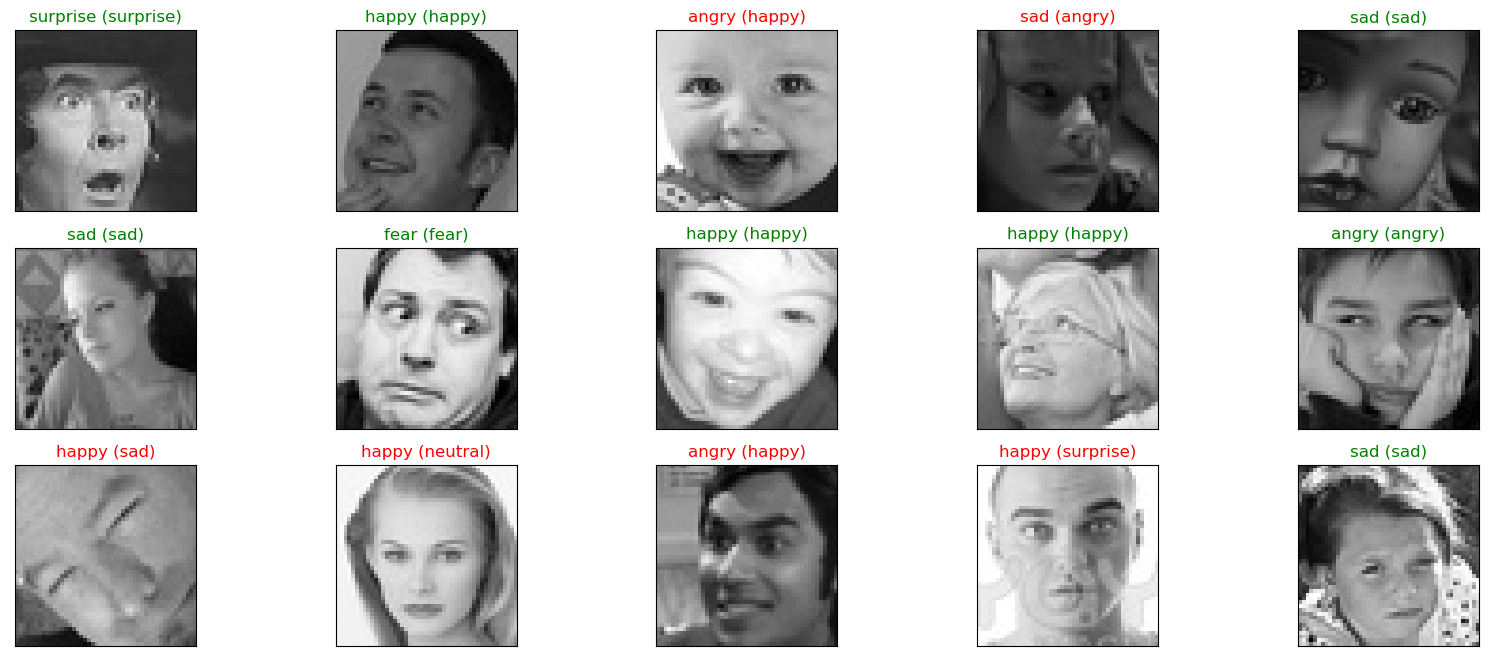

In [50]:
y_pred3 = model_transfer.predict(x_test_shuffled)
visualise_few_images(y_pred3)

In [51]:
stats(y_pred3)

              precision    recall  f1-score   support

       angry       0.44      0.40      0.42       960
     disgust       0.64      0.38      0.47       111
        fear       0.39      0.39      0.39      1018
       happy       0.66      0.72      0.69      1824
     neutral       0.48      0.44      0.46      1216
         sad       0.41      0.45      0.43      1139
    surprise       0.70      0.66      0.68       797

    accuracy                           0.53      7065
   macro avg       0.53      0.49      0.51      7065
weighted avg       0.53      0.53      0.52      7065



Ways toimprove accuracy:
- Change in noof layers
- Change inactivation function, optimizers etc
- Change in data pre processing like reduction in image size, rotationsetc
- Increase / decrease in noof images
- balancing no of images in each class